In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch import device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
from dataclasses import dataclass
import math
torch.set_float32_matmul_precision('high')



Using device: cuda


## Model Architecture

In [2]:
@dataclass
class gpt2config:
    n_vocab: int = 50257
    n_layer: int = 12
    n_embed: int = 128
    n_context: int = 1024
    n_head: int = 8
    n_timesteps: int = 1000


In [3]:
class GPT2Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed)
        self.c_proj = nn.Linear(config.n_embed, config.n_embed)
        self.n_head = config.n_head
        self.n_embed = config.n_embed
        
        # Create a causal mask (lower triangular matrix) and register it as a buffer
        # A buffer is not a parameter, but is saved with the model state_dict
        self.register_buffer("bias", torch.tril(torch.ones(config.n_context, config.n_context))
                                     .view(1, 1, config.n_context, config.n_context))

    def forward(self, x):
        B, T, C = x.size()
        
        # Calculate query, key, values for all heads in batch
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embed, dim=2)
        
        # Reshape for multi-head attention: (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Scaled dot-product attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))
        
        # --- MASKING STARTS HERE ---
        # Apply the causal mask: fill "future" positions with -infinity
        # This makes their softmax probability zero.
        # att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # --- MASKING ENDS HERE ---

        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, hs)
        
        # Re-assemble all head outputs side-by-side
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        
        # Output projection
        y = self.c_proj(y)
        return y
    
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embed, 4*config.n_embed)
        self.act = nn.GELU(approximate="tanh")
        self.c_proj = nn.Linear(4*config.n_embed, config.n_embed)

    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        return x
    

class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.ln1 = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        self.attn = GPT2Attention(config)
        self.ln2 = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        self.mlp = GPT2MLP(config)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) #
        # TODO: Double check the ordering here
        return embeddings

In [5]:
sine_embeds = SinusoidalPositionEmbeddings(100)
time = 10
time = torch.tensor([time], device=device)
out = sine_embeds(time)
out.shape

torch.Size([1, 100])

In [6]:
class LMEmbedding(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config

        self.embed = nn.Embedding(config.n_vocab,config.n_embed)
    
    def forward(self,input_ids):
        x = self.embed(input_ids)
        
        return x
        


In [7]:
class Denoiser(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            # wte = nn.Embedding(config.n_vocab,config.n_embed),
            wpe = nn.Embedding(config.n_context,config.n_embed),
            drop = nn.Dropout(0.1,inplace=False),
            h = nn.ModuleList(Block(config) for _ in range(config.n_layer)),
            ln_f = nn.LayerNorm(config.n_embed,eps=1e-5,elementwise_affine=True)
        ))
        
        # self.lm_head = nn.Linear(config.n_embed, config.n_vocab, bias=False)

        self.small_mlp = nn.Linear(config.n_embed, config.n_embed)

        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(config.n_embed),
            nn.Linear(config.n_embed, config.n_embed),
            nn.GELU()
            )

    def forward(self,input_embeddings,time_step, targets=None):
        B,T,C = input_embeddings.size()
        device = input_embeddings.device

        pos = torch.arange(0,T,dtype=torch.long,device=device).unsqueeze(0)  # (1,T)
        x = input_embeddings +  self.transformer.wpe(pos)  # (B,T,C) pytorch does braodcasting for the position embeddingss and adds them to the token embeddings 
        
        time_emb = self.time_embed(time_step) # (B, C)
        x= x + time_emb.unsqueeze(1)  # (B, T, C)
        
        x = self.transformer.drop(x)


        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)  # (B,T,C)
        # logits = self.lm_head(x)  # (B,T,vocab_size) 
        # we don't need the head since we are not doing autoregressive language modeling
        
        # we want to predict the starting sequence before the noising part.
        x = self.small_mlp(x)  # (B,T,C)
        
        return x

In [8]:
class Decoding(nn.Module):
    def __init__(self,config):
        super().__init__()
    # takes x0 (B,T,C) and give a softmax over vocab size           
        self.l1 = nn.Linear(config.n_embed, config.n_vocab, bias=False)
        
        
    def forward(self,x):
        x = self.l1(x)
        # x = F.softmax(x,dim=-1)

        return x

In [9]:
class DiffusionLM(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.embedding = LMEmbedding(config)
        self.denoiser = Denoiser(config)
        self.decoder = Decoding(config)
        
    def forward(self,input_ids,time_step, targets=None):
        input_embeddings = self.embedding(input_ids)  # (B,T,C)
        x = self.denoiser(input_embeddings,time_step, targets)  # (B,T,C)
        logits = x@self.embedding.embed.weight.T  # (B,T,vocab_size)
        
        return x, logits

## Tokenizer

In [10]:
import tiktoken

# 1. Load the tokenizer for GPT-4o
tokenizer = tiktoken.get_encoding("r50k_base")
print("vocab:",tokenizer.n_vocab)
# 2. Convert text to tokens
text = "Hello, tiktoken is fast!"
tokens = tokenizer.encode(text)
print(f"Token IDs: {tokens}")
print(f"Token Count: {len(tokens)}")

# 3. Convert back to original text
decoded_text = tokenizer.decode(tokens)
print(f"Decoded: {decoded_text}")


config = gpt2config(n_vocab=tokenizer.n_vocab)
print(config)

vocab: 50257
Token IDs: [15496, 11, 256, 1134, 30001, 318, 3049, 0]
Token Count: 8
Decoded: Hello, tiktoken is fast!
gpt2config(n_vocab=50257, n_layer=12, n_embed=128, n_context=1024, n_head=8, n_timesteps=1000)


In [11]:
# emb_func = LMEmbedding(config).to(device)
# model = Denoiser(config).to(device)
# decoder = Decoding(config).to(device)
# print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
# print(f"Embedding parameters: {sum(p.numel() for p in emb_func.parameters())/1e6:.2f}M")
# print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters())/1e6:.2f}M")
model = DiffusionLM(config).to(device)
print(f"Total Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Total Model parameters: 15.41M


In [12]:
sample_input = "Once upon a time in a land far away, there lived a"
sample_tokens = tokenizer.encode(sample_input)
sample_input_ids = torch.tensor([sample_tokens], device=device)  # (1, sequence_length)
sample_time_step = torch.tensor([10], device=device)  # (1,)

In [13]:
sample_input_ids.shape

torch.Size([1, 13])

In [14]:
sample_output, sample_logits = model(sample_input_ids, sample_time_step)  # (1, sequence_length, n_embed)

def finalize_tokens(x0_final, embedding_weights):
    """
    Converts the final denoised latent into discrete token IDs.
    Args:
        x0_final: Tensor of shape (B, T, C)
        embedding_weights: Tensor of shape (Vocab, C)
    """
    # Fix: x2 must be 3D to match x1 (B, T, C)
    # Unsqueeze(0) makes it (1, Vocab, C), and PyTorch broadcasts it to (B, Vocab, C)
    distances = torch.cdist(x0_final, embedding_weights.unsqueeze(0), p=2) #(B,T,Vocab)  
    token_ids = torch.argmin(distances, dim=-1) #(B, T)
    
    return token_ids

token_ids = finalize_tokens(sample_output, model.embedding.embed.weight)
decoded_output = tokenizer.decode(token_ids.squeeze(0).tolist())
print("Decoded Text:",decoded_output)



Decoded Text:  recruitedcasts Nobel Jebytesbable Pop Gauntlet crushedtrialHar LV drowning


## Forward Diffusion

In [15]:
def get_alphas(T=2000, s=1e-4):
    """
    Computes the bar_alpha (signal) schedule for Diffusion-LM[cite: 232, 483].
    s: constant determining initial noise level (standard dev = 0.1)[cite: 515].
    """
    t = torch.linspace(0, T, T + 1)
    # Sqrt schedule: alpha_bar = 1 - sqrt(t/T + s) 
    alphas = 1 - torch.sqrt(t / T )
    
    return alphas

In [16]:
def fwd_diffusion(x0, t, alphas):
    """
    Directly samples x_t from x_0 at a specific timestep[cite: 109, 170].
    
    Args:
        x0: Clean embeddings (B, SeqLen, EmbedDim) [cite: 126]
        t: Timesteps for the batch (B,) 
        alphas: Precomputed signal schedule from get_alphas()
    """
    # Select alpha_bar for each batch item and reshape for broadcasting
    a = alphas[t].view(-1, 1, 1).to(x0.device)
    
    # Sample Gaussian noise with same shape as x0
    noise = torch.randn_like(x0)
    
    # Formula: x_t = sqrt(alpha_bar) * x0 + sqrt(1 - alpha_bar) * noise [cite: 169]
    print("sqrt a avg:",torch.sqrt(a).mean())
    xt = torch.sqrt(a) * x0 + torch.sqrt(1 - a) * noise
    
    return xt

In [17]:
alphas = get_alphas().to(device)

noisy_input = fwd_diffusion(model.embedding(sample_input_ids), torch.tensor([1000], device=device), alphas)

sqrt a avg: tensor(0.5412, device='cuda:0')


In [18]:
print(model.embedding.embed.weight.std())

tensor(1.0004, device='cuda:0', grad_fn=<StdBackward0>)


In [19]:
F.mse_loss(noisy_input,sample_output)

tensor(1.2818, device='cuda:0', grad_fn=<MseLossBackward0>)

In [20]:

token_ids = finalize_tokens(noisy_input, model.embedding.embed.weight)
decoded_output = tokenizer.decode(token_ids.squeeze(0).tolist())
print("Decoded Text:",decoded_output)

Decoded Text: Once conserv a time in a land far away, there lived a


## Loading Datasets

In [21]:
# Load tiny shakespeare dataset
with open('datasets/ROCStories_train.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Dataset length: {len(text)} characters")
print(f"First 100 characters:\n{text[0:100]}")

Dataset length: 18007898 characters
First 100 characters:
The boy went to a video arcade. He played his favorite machine. His games didn't go very well. He to


In [22]:
# Encode the entire dataset
data = tokenizer.encode(text)
print(f"Encoded length: {len(data)} tokens")

# Split into train and validation
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

print(f"Train tokens: {len(train_data)}, Val tokens: {len(val_data)}")

Encoded length: 4111142 tokens
Train tokens: 3700027, Val tokens: 411115


In [23]:
# Data loader function
def get_batch(split, batch_size=8, block_size=256):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    w_stack = torch.stack([torch.tensor(data[i:i+block_size]) for i in ix])
    # y = torch.stack([torch.tensor(data[i+1:i+block_size+1]) for i in ix])
    w_stack = w_stack.to(device)
    return w_stack

# Test batch
w_stack = get_batch('train')
print(f"Batch shape: {w_stack.shape}")
print(w_stack)

Batch shape: torch.Size([8, 256])
tensor([[ 6939,   607,  7457,  ...,   561,  6576,   465],
        [  973,   284,   711,  ...,   284,  2266,    78],
        [  510, 34161,    13,  ...,  5198,    13,  1119],
        ...,
        [ 1194, 12699,  5466,  ...,   373,  3375,   546],
        [   13, 21418,  3016,  ...,   494,  4721,   510],
        [   13,  1649,   340,  ...,   329,   262,  1524]], device='cuda:0')


## Training Loop


In [24]:
from torch.optim.lr_scheduler import LambdaLR

In [25]:
# Training configuration
max_iters = 100000  
eval_interval = 10  # Evaluate less frequently
learning_rate = 1e-4
eval_iters = 200  # Much fewer eval iterations (was 200!)
batch_size = 32  # Larger batch for better GPU utilization
sequence_length = 64
T = 500
num_timestep_samples = 16  # Sample 8 timesteps per iteration for better gradient estimate

# alphas = get_alphas(T=T,s=1e-4).to(device)

In [26]:
# Fixed alpha schedule - simple sqrt schedule
t = torch.arange(1, T+1, device=device, dtype=torch.float32)

# Simple sqrt schedule: alpha_bar decreases as sqrt
alpha_bars = 1 - torch.sqrt(t / T)  # Goes from ~0 to 1-sqrt(1)=0
# Ensure alpha_bars stays in valid range [0, 1)
alpha_bars = torch.clamp(alpha_bars, min=1e-4, max=0.999)

# Compute individual alphas from alpha_bars
# alpha_bar_t = product of alpha_1 * alpha_2 * ... * alpha_t
alphas = torch.zeros(T, device=device)
alphas[0] = alpha_bars[0]
alphas[1:] = alpha_bars[1:] / alpha_bars[:-1]
alphas = torch.clamp(alphas, min=0.01, max=0.999)

# Precompute sqrt terms for efficiency
sqrt_ab = torch.sqrt(alpha_bars)
sqrt_1mab = torch.sqrt(1 - alpha_bars)

print(f"Alpha bars range: [{alpha_bars.min():.4f}, {alpha_bars.max():.4f}]")
print(f"Alphas range: [{alphas.min():.4f}, {alphas.max():.4f}]")


Alpha bars range: [0.0001, 0.9553]
Alphas range: [0.1000, 0.9960]


In [27]:
def posterior_mean(x_t, x0, t, alpha_bars):
    abar_t = alpha_bars[t-1]
    abar_tm1 = alpha_bars[t-2] if t > 1 else torch.tensor(1.0, device=x0.device)

    coef1 = torch.sqrt(abar_tm1) * (1 - abar_t / abar_tm1) / (1 - abar_t)
    coef2 = torch.sqrt(abar_t / abar_tm1) * (1 - abar_tm1) / (1 - abar_t)

    return coef1 * x0 + coef2 * x_t


In [28]:
optimizer_model = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=0.0)
lr_lambda = lambda step: 1.0 - (step / float(max_iters))
scheduler_model = LambdaLR(optimizer_model, lr_lambda=lr_lambda)

In [29]:
for it in range(max_iters):

    w = get_batch('train', batch_size, sequence_length)   # (B,L)
    w_emb = model.embedding(w)                            # (B,L,d)

    # ---- sample x0 with small noise ----
    x0 = w_emb + 0.1 * torch.randn_like(w_emb)

    total_loss = 0.0

    
    # ---- Sample multiple timesteps to approximate E_t[loss] ----
    # This gives a better gradient estimate than sampling just one timestep
    denoising_loss = 0.0
    for _ in range(num_timestep_samples):
        t_random = torch.randint(1, T+1, (batch_size,), device=device)
        
        # Generate noised version at those timesteps
        t_idx = t_random - 1  # Convert to 0-indexed
        sqrt_ab_t = sqrt_ab[t_idx].view(batch_size, 1, 1)
        sqrt_1mab_t = sqrt_1mab[t_idx].view(batch_size, 1, 1)
        
        xt = sqrt_ab_t * x0 + sqrt_1mab_t * torch.randn_like(x0)
        x0_hat = model.denoiser(xt, t_random)
        
        # Accumulate denoising loss over sampled timesteps
        denoising_loss += F.mse_loss(x0_hat, x0)
    
    # Average over timestep samples
    denoising_loss = denoising_loss / num_timestep_samples
    total_loss += denoising_loss
    
    # ---- Posterior mean regularization at timestep T ----
    # Sample at the final timestep T
    t_T = torch.full((batch_size,), T, device=device)
    xT = sqrt_ab[-1] * x0 + sqrt_1mab[-1] * torch.randn_like(x0)
    
    # Predict x0 from xT
    x0_hat_T = model.denoiser(xT, t_T)
    
    # Compute posterior mean and regularize it to be close to zero
    mu_hat_T = posterior_mean(xT, x0_hat_T, T, alpha_bars)
    posterior_loss = mu_hat_T.pow(2).mean()
    total_loss += posterior_loss

    # ---- t=1 anchor loss (every iteration for stability) ----
    # This ensures the denoised output matches actual word embeddings
    xt_1 = sqrt_ab[0] * x0 + sqrt_1mab[0] * torch.randn_like(x0)
    x0_hat_1 = model.denoiser(xt_1, torch.ones(batch_size, device=device))
    anchor_loss = F.mse_loss(x0_hat_1, w_emb)
    total_loss += anchor_loss

    # ---- rounding loss (tied weights) ----
    # Use x0_hat_1 from anchor step for rounding loss
    logits = torch.matmul(x0_hat_1, model.embedding.embed.weight.T)  # (B,L,V)
    rounding_loss = F.cross_entropy(logits.view(-1, config.n_vocab), w.view(-1))
    total_loss += 0.5 * rounding_loss  # Scale to balance losses

    # ---- optimize ----
    optimizer_model.zero_grad(set_to_none=True)
    total_loss.backward()
    
    # Gradient clipping to prevent exploding gradients
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer_model.step()
    scheduler_model.step()

    if it % eval_iters == 0:
        print(f"Iter {it}: loss = {total_loss.item():.4f}, denoising = {denoising_loss.item():.4f}, posterior = {posterior_loss.item():.4f}, anchor = {anchor_loss.item():.4f}, rounding = {rounding_loss.item():.4f}")


Iter 0: loss = 16.3810, denoising = 1.3462, posterior = 0.0995, anchor = 1.3275, rounding = 27.2157
Iter 200: loss = 1.7378, denoising = 0.8848, posterior = 0.1023, anchor = 0.6682, rounding = 0.1648
Iter 400: loss = 1.4902, denoising = 0.8132, posterior = 0.1021, anchor = 0.5634, rounding = 0.0230
Iter 600: loss = 1.3506, denoising = 0.7501, posterior = 0.1014, anchor = 0.4849, rounding = 0.0284
Iter 800: loss = 1.2681, denoising = 0.7171, posterior = 0.1013, anchor = 0.4436, rounding = 0.0122
Iter 1000: loss = 1.1803, denoising = 0.6797, posterior = 0.1016, anchor = 0.3975, rounding = 0.0031
Iter 1200: loss = 1.1284, denoising = 0.6597, posterior = 0.1017, anchor = 0.3670, rounding = 0.0001


KeyboardInterrupt: 

In [ ]:
# for it in range(max_iters):

#     # --------------------------------------------------
#     # 1. Get data and sample x0
#     # --------------------------------------------------
#     w = get_batch('train', batch_size, sequence_length)   # (B, L)
#     w_emb = model.embedding(w)                            # (B, L, d)

#     x0 = w_emb + 0.1 * torch.randn_like(w_emb)            # (B, L, d)

#     B, L, d = x0.shape
#     T = sqrt_ab.shape[0]

#     # --------------------------------------------------
#     # 2. Build xt for ALL timesteps (vectorized)
#     # --------------------------------------------------
#     x0_expand = x0.unsqueeze(0)                            # (1, B, L, d)
#     eps = torch.randn(T, B, L, d, device=device)

#     xt = (
#         sqrt_ab.view(T, 1, 1, 1) * x0_expand +
#         sqrt_1mab.view(T, 1, 1, 1) * eps
#     )                                                      # (T, B, L, d)

#     # --------------------------------------------------
#     # 3. Flatten (T, B) → (T*B) for denoiser
#     # --------------------------------------------------
#     xt_flat = xt.view(T * B, L, d)

#     t_idx = torch.arange(1, T + 1, device=device)
#     t_flat = t_idx.repeat_interleave(B)                    # (T*B,)

#     x0_hat_flat = model.denoiser(xt_flat, t_flat)
#     x0_hat = x0_hat_flat.view(T, B, L, d)                  # (T, B, L, d)

#     # --------------------------------------------------
#     # 4. Loss terms
#     # --------------------------------------------------

#     loss = 0.0

#     # ---- (a) T regularizer ----
#     mu_hat_T = posterior_mean(
#         xt[-1], x0, T, alphas, alpha_bars
#     )
#     loss += mu_hat_T.pow(2).mean()

#     # ---- (b) t = 2..T reconstruction ----
#     loss += (x0_hat[1:] - x0.unsqueeze(0)).pow(2).mean()

#     # ---- (c) t = 1 anchor ----
#     loss += (x0_hat[0] - w_emb).pow(2).mean()

#     # ---- (d) rounding loss (tied weights!) ----
#     W = model.embedding.embed.weight                       # (V, d)
#     logits = torch.matmul(x0, W.T)                        # (B, L, V)

#     loss += F.cross_entropy(
#         logits.view(-1, config.n_vocab),
#         w.view(-1)
#     )

#     # --------------------------------------------------
#     # 5. Optim step
#     # --------------------------------------------------
#     optimizer_model.zero_grad(set_to_none=True)
#     loss.backward()
#     optimizer_model.step()
#     scheduler_model.step()

#     if it % eval_iters == 0:
#         print(f"Iter {it}: loss = {loss.item():.4f}")


In [ ]:
# # decoder.l1.weight = emb_func.embed.weight
# for iter in range(max_iters):
#     # model.eval()
#     # decoder.eval()
#     # emb_func.eval()
#     w = get_batch('train', batch_size,block_size=sequence_length)  # already on device
#     w_emb = model.embedding(w)  # (B, T, C)
#     x0 = w_emb + 0.1 * torch.randn_like(w_emb)  # use randn_like for Gaussian noise
    
#     total_loss = 0
#     mu_T = fwd_diffusion(x0,torch.tensor([T]*batch_size,device=device),alphas)
#     total_loss += torch.mean(mu_T**2)
#     # print(total_loss)
#     # for t_step in range(T + 1):
#         # t_tensor = torch.tensor([t_step] * batch_size, device=device)
        
#     t_tensor = torch.randint(1, T + 1, (batch_size,), device=device)
#     xt = fwd_diffusion(x0, t_tensor, alphas)
#     x0_cap = model.denoiser(xt, t_tensor)   # (B, T, C) , (B, T, V)
#     total_loss += F.mse_loss(x0_cap, x0)
    
#     # Final step loss
#     t_one = torch.tensor([1] * batch_size, device=device)
#     total_loss += F.mse_loss(model.denoiser(fwd_diffusion(x0, t_one, alphas), t_one), w_emb)

#     # Decoder cross-entropy loss
#     logits = x0_cap @ model.embedding.embed.weight.T  # (B, T, V)
#     V = config.n_vocab
#     logits_flat = logits.view(-1, V)  # (B*T, V)
#     targets_flat = w.view(-1)  # (B*T,)
#     # print(F.cross_entropy(logits_flat, targets_flat).item())
#     total_loss += F.cross_entropy(logits_flat, targets_flat)
#     # print(log_loss)

#     optimizer_model.zero_grad(set_to_none=True)
#     # optimizer_model_decoder.zero_grad(set_to_none=True)
#     # optimizer_emb.zero_grad(set_to_none=True)
#     total_loss.backward()
#     optimizer_model.step() 
#     # optimizer_model_decoder.step()
#     # optimizer_emb.step()

#     scheduler_model.step()
#     # scheduler_model_decoder.step()
#     # scheduler_emb.step()

#     # radius = 9
#     # with torch.no_grad():
#     #     # Projects all vectors back to a radius of 1.0
#     #     emb_func.embed.weight.div_(torch.norm(emb_func.embed.weight, dim=-1, keepdim=True)).mul_(radius)
#     if iter%eval_iters == 0:
#         print(f"Iter {iter}: Loss {total_loss.item()}")
#         # print("Embedding norm stats:",
#         #       f"min {torch.norm(model.embedding.embed.weight, dim=-1).min().item():.4f},")

In [30]:
def reverse_diffusion_with_clamping(model, alphas, T, context_length=50, batch_size=1):

    model.eval()
    
    # Start from pure noise: x_T ~ N(0, I)
    x_t = torch.randn(batch_size, context_length, config.n_embed, device=device)
    
    with torch.no_grad():
        # Reverse diffusion: t = T, T-1, ..., 1, 0
        for t_step in reversed(range(T + 1)):
            if t_step % 1 == 0 or t_step == T:
                pass
            else:
                continue 
            
            # print(f"Denoising step {t_step}/{T}")
            
            # if t_step == 0:
            #     # Final step: just clamp to get x_0
            #     x_0 = x_t
            #     break
            
            # Create timestep tensor for batch
            t_tensor = torch.tensor([t_step] * batch_size, device=device)
            
            # Predict x_0 from x_t using the denoiser
            x0_pred = model.denoiser(x_t, t_tensor)
            
            # CLAMPING TRICK: Map predicted x_0 to nearest word embedding
            # This forces intermediate predictions to be valid words
            x0_clamped_tokens = finalize_tokens(x0_pred, model.embedding.embed.weight)
            x0_clamped = model.embedding(x0_clamped_tokens)  # (B, T, C)
            
            # Compute x_{t-1} using the formula:
            # x_{t-1} = sqrt(alpha_{t-1}) * x0_clamped + sqrt(1 - alpha_{t-1}) * epsilon
            
            alpha_t_prev = alphas[t_step - 1] if t_step > 0 else alphas[0]
            
            # Sample fresh noise
            epsilon = torch.randn_like(x_t)
            
            # Update: x_{t-1} = sqrt(alpha_{t-1}) * x0_clamped + sqrt(1 - alpha_{t-1}) * epsilon
            x_t = torch.sqrt(alpha_t_prev) * x0_clamped + torch.sqrt(1 - alpha_t_prev) * epsilon
    
            # Final denoised embeddings: x_0
            x0_final = x_t
            
            # Convert to tokens using argmin rounding with learned embeddings
            generated_tokens = finalize_tokens(x0_final, model.embedding.embed.weight)
            
            # Decode to text
            generated_text = []
            for i in range(batch_size):
                text = tokenizer.decode(generated_tokens[i].tolist())
                generated_text.append(text)
            
            if t_step % 50 == 0 or t_step == T:
                print(f"\nTimestep {t_step}:")
                for i in range(batch_size):
                    print(f"Sample {i+1}: {generated_text[i]}")

    return generated_tokens, generated_text


# Run inference

# print("\n" + "="*50)
# print("GENERATED TEXT:")
# print("="*50)
# print(generated_text[0])
# print("="*50)

## Inference

In [31]:
print("Starting reverse diffusion inference with clamping...")
context_length = 128
generated_tokens, generated_text = reverse_diffusion_with_clamping(
    model=model,
    alphas=alphas,
    T=T,
    context_length=context_length,
    batch_size=1
)

Starting reverse diffusion inference with clamping...

Timestep 500:
Sample 1: ueller Realm shrueller unmatched Frances shr Frances Frances mus init mus;" Events mus shr musNotes mus constructionmatched mus oceanEgyptueller shr Herauddin shr mus mus emphasis shr nervousinkerueller Madduddin shr Task Francesuddin shruddin ravenforum Favor ouths shr mus dystopian musropy Francesinders Holt mus outuddin canctl United RaleighCorn musuddin shr. glowguyen方 appeareduddinmatched mus?", prayuddin mathematic FrancesUSD mus150 provocation outuddinuelleruddin Heramatchedumersuddin mus mus Frances joystick Shinra background Fired shr YepIm slid celebaaa DIm Cannottrial revolvesether heck rhyth nonsensical gasesuador;" Turkey Frances outIm shr electingmatched andmatched Sector

Timestep 450:
Sample 1: uelleruddin shrueller.uellerueller. Frances.uddin mus Herauddin. shr a. a Francesmatched.uelleruellerueller shr Hera. shr mus mus Frances..uelleruelleruelleruddin shr Francesuddinuddin shr. Hera shr sh

## Visualizing the Embedding Space

In [ ]:
# from openTSNE import TSNE as FastTSNE
# from sklearn.decomposition import PCA
# import plotly.express as px

In [ ]:
# @torch.no_grad()
# def visualize_embeddings_fast(emb_func, vocab_list):
#     # 1. Get raw embeddings
#     embeddings = emb_func.weight[:100].detach().cpu().numpy()
    
#     # 2. PCA Pre-reduction (Speed up the t-SNE neighbor search)
#     print("Pre-reducing dimensions with PCA...")
#     pca_embeddings = PCA(n_components=50).fit_transform(embeddings)

#     # 3. Fast t-SNE (openTSNE)
#     # n_jobs=-1 uses all available CPU cores
#     print("Running fast t-SNE (openTSNE)...")
#     tsne = FastTSNE(
#         n_components=2, 
#         perplexity=30, 
#         initialization="pca", 
#         n_jobs=-1,
#         random_state=42
#     )
#     embeds_3d = tsne.fit(pca_embeddings)

#     # 3. Create a DataFrame for Plotly
#     import pandas as pd
#     df = pd.DataFrame({
#         'x': embeds_3d[:, 0],
#         'y': embeds_3d[:, 1],
#         'word': vocab_list
#     })

#     # 4. Plotly Interactive 2D Scatter
#     fig = px.scatter(df, x='x', y='y', text='word', 
#                      title="Diffusion-LM Embedding Space (2D t-SNE)")
#     fig.update_traces(marker=dict(size=2))
#     fig.show()

In [32]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

def visualize_static_3d(emb_func, vocab_list, top_n=500):
    # 1. Force everything to CPU and Float32 immediately
    embeddings = emb_func.embed.weight[:top_n].detach().cpu().float().numpy()
    
    print(f"Running t-SNE on {top_n} points...")
    # Lower perplexity for fewer points to prevent hanging
    tsne = TSNE(n_components=3, perplexity=min(30, top_n-1), init='pca', verbose=1)
    embeds_3d = tsne.fit_transform(embeddings)

    # 2. Simple Matplotlib 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(embeds_3d[:, 0], embeds_3d[:, 1], embeds_3d[:, 2], alpha=0.6)
    
    # Label a few random points so you can see if words cluster
    for i in range(0, top_n, top_n // 10): 
        ax.text(embeds_3d[i, 0], embeds_3d[i, 1], embeds_3d[i, 2], vocab_list[i])

    plt.title("Static 3D Embedding View")
    plt.show()

In [33]:
# visualize_static_3d(emb_func, my_vocab_itos_list[:1000], top_n=1000)

In [34]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

@torch.no_grad()
def visualize_embeddings_2d(emb_func, vocab_list, top_n=5000):
    # 1. Extract and Clean Data
    # Convert to CPU, Float32, and Numpy immediately to prevent hanging
    embeddings = emb_func.weight[:top_n].detach().cpu().float().numpy()
    
    # 2. PCA Pre-reduction (768 -> 50)
    # This removes noise and makes t-SNE significantly faster and more stable
    print("Pre-reducing dimensions with PCA...")
    pca = PCA(n_components=50)
    embeddings_reduced = pca.fit_transform(embeddings)

    # 3. 2D t-SNE
    print(f"Running 2D t-SNE on {top_n} tokens...")
    # perplexity 30 is standard; init='pca' is faster than 'random'
    tsne = TSNE(n_components=2, perplexity=30, init='pca', verbose=1, random_state=42)
    embeds_2d = tsne.fit_transform(embeddings_reduced)

    # 4. Plotting with Matplotlib (Reliable & Fast)
    plt.figure(figsize=(12, 10))
    plt.scatter(embeds_2d[:, 0], embeds_2d[:, 1], alpha=0.5, s=5, c='blue')

    # Label a subset of words to verify clusters
    # We label every 100th word so the plot isn't a mess of text
    for i in range(0, top_n, 100):
        plt.annotate(vocab_list[i], (embeds_2d[i, 0], embeds_2d[i, 1]), 
                     fontsize=8, alpha=0.8, weight='bold')

    plt.title(f"Diffusion-LM Latent Space (Top {top_n} Tokens)")
    plt.grid(True, alpha=0.3)
    plt.show()

In [35]:
my_vocab_itos_list = [tokenizer.decode([i]) for i in range(config.n_vocab)]

Pre-reducing dimensions with PCA...
Running 2D t-SNE on 3000 tokens...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.000s...
[t-SNE] Computed neighbors for 3000 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.163881
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.651779
[t-SNE] KL divergence after 1000 iterations: 3.608171


/home/utsab/miniconda3/envs/IRL_AGV/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


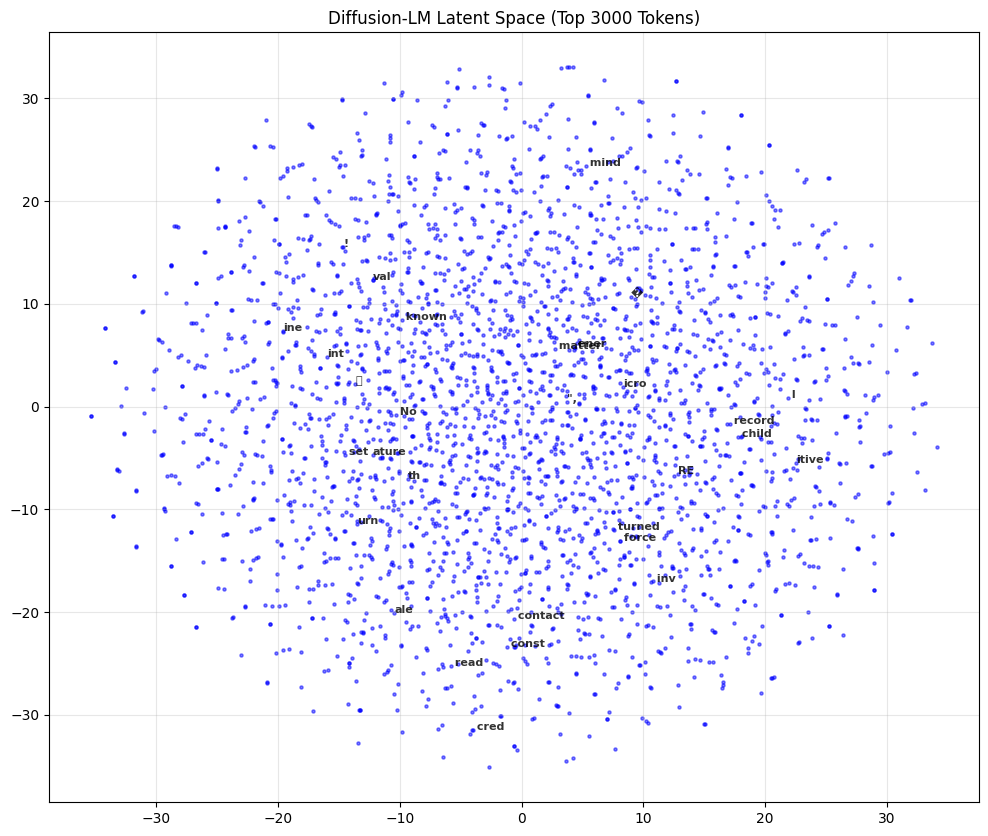

In [36]:
visualize_embeddings_2d(model.embedding.embed, my_vocab_itos_list[:3000], top_n=3000)

In [ ]:
# # Save model checkpoints
# import os

# # Create checkpoints directory if it doesn't exist
# checkpoint_dir = 'saved_models/checkpoints__2k_100k_norm'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Save all three model components
# checkpoint = {
#     'config': config,
#     'emb_func_state_dict': emb_func.state_dict(),
#     'model_state_dict': model.state_dict(),
#     'decoder_state_dict': decoder.state_dict(),
#     'alphas': alphas,
#     'T': T
# }

# checkpoint_path = os.path.join(checkpoint_dir, 'diff_lm_checkpoint.pt')
# torch.save(checkpoint, checkpoint_path)
# print(f"Checkpoint saved to {checkpoint_path}")

# # Optionally, also save individual components
# torch.save(emb_func.state_dict(), os.path.join(checkpoint_dir, 'emb_func.pt'))
# torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'denoiser_model.pt'))
# torch.save(decoder.state_dict(), os.path.join(checkpoint_dir, 'decoder.pt'))
# print("Individual model components saved separately")